In [11]:
from pyod.utils.data import generate_data

n_features = 2
n_samples = 100
train_percent = 0.8
X_train, X_test, y_train, y_test = generate_data(
    n_train=int(n_samples * train_percent),
    n_test=n_samples - int(n_samples * train_percent),
    n_features=n_features,
    contamination=0.1,
    random_state=42
)
# Anomalies should be labeled -1, normal points should be labeled 1
# Now they are 0 (normal) and 1 (anomaly)
y_train[y_train == 1] = -1
y_test[y_test == 1] = -1
y_train[y_train == 0] = 1
y_test[y_test == 0] = 1


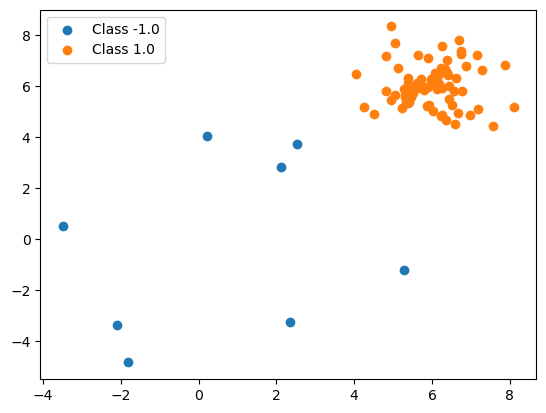

In [12]:
# Plot the data using feature 1 and feature 2
import matplotlib.pyplot as plt
import numpy as np
for c in np.unique(y_train):
    plt.scatter(X_train[y_train==c, 0], X_train[y_train==c, 1], label=f'Class {c}')
plt.legend()
plt.show()


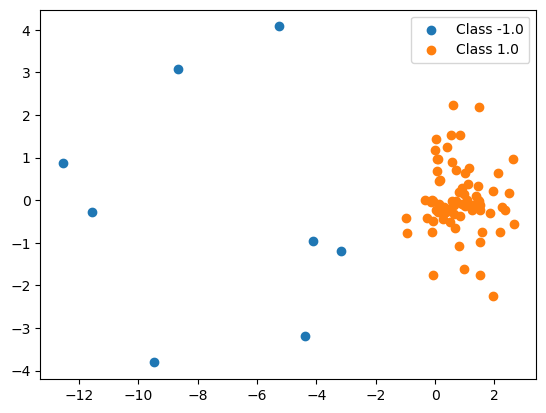

In [13]:
# Plot the data using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
for c in np.unique(y_train):
    plt.scatter(X_pca[y_train==c, 0], X_pca[y_train==c, 1], label=f'Class {c}')
plt.legend()
plt.show()


In [14]:
# Make benchmark with OneClassSVM
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, accuracy_score
ocsvm = OneClassSVM()
ocsvm.fit(X_train)
# Print training accuracy
y_pred_train = ocsvm.predict(X_train)
print("Training:")
print(classification_report(y_train, y_pred_train))
# Print test accuracy
y_pred = ocsvm.predict(X_test)
print("Test:")
print(classification_report(y_test, y_pred))


Training:
              precision    recall  f1-score   support

        -1.0       0.20      1.00      0.33         8
         1.0       1.00      0.56      0.71        72

    accuracy                           0.60        80
   macro avg       0.60      0.78      0.52        80
weighted avg       0.92      0.60      0.68        80

Test:
              precision    recall  f1-score   support

        -1.0       0.17      1.00      0.29         2
         1.0       1.00      0.44      0.62        18

    accuracy                           0.50        20
   macro avg       0.58      0.72      0.45        20
weighted avg       0.92      0.50      0.58        20



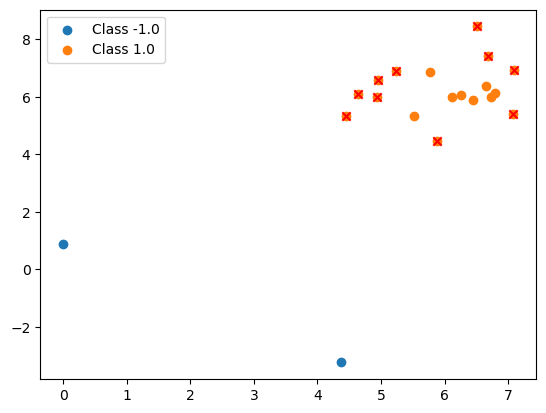

In [15]:
# Visualize the data putting red crosses on data not correctly classified (for test)
for c in np.unique(y_test):
    plt.scatter(X_test[y_test==c, 0], X_test[y_test==c, 1], label=f'Class {c}')
for i in range(len(y_test)):
    # red crosses for misclassified points
    if y_test[i] != y_pred[i]:
        plt.scatter(X_test[i, 0], X_test[i, 1], color='red', marker='x')
plt.legend()
plt.show()



In [16]:
n_qubits = X_train.shape[1]
print(f"Number of qubits: {n_qubits}")

Number of qubits: 2


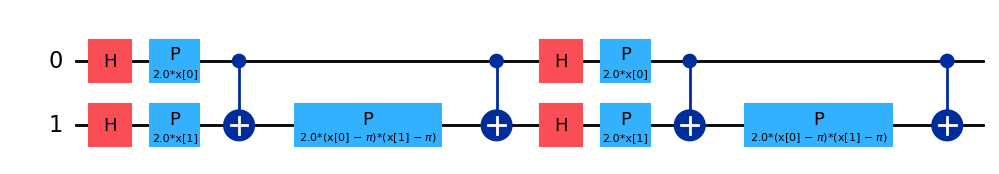

In [17]:
from qiskit.circuit.library import zz_feature_map
# Create the encoding circuit
enc_qc = zz_feature_map(n_qubits,parameter_prefix='x')

enc_qc.draw('mpl', fold=-1)

In [18]:
from qiskit_ibm_runtime import Estimator
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, SparsePauliOp

def run_estimator(pubs, shots):
    backend = AerSimulator()
    estimator = Estimator(mode=backend, options={'default_shots': shots})

    job = estimator.run(pubs)
    return job.result()

def define_0s_fidelity_operator(n_qubits):
    """
    Define the fidelity operator based on the target state.

    Args:
        n_qubits (int): The number of qubits.

    Returns:
        SparsePauliOp: The fidelity operator.
    """
    statevector = Statevector.from_label('0' * n_qubits)
    operator = statevector.to_operator()
    # Convert the operator to a SparsePauliOp
    return SparsePauliOp.from_operator(operator)

In [19]:
# Kernel is ComputeUncompute
def kernel(X1, X2):
    """Compute the kernel between two sets of data points."""
    # Create 2 copies of the encoding circuit
    enc_qc1 = enc_qc.copy()
    enc_qc2 = enc_qc.copy()
    # Bind the parameters of the encoding circuit to the data points
    assigned_enc_1 = enc_qc1.assign_parameters(X1, inplace=False)
    assigned_enc_2 = enc_qc2.assign_parameters(X2, inplace=False)
    # Make dagger of the second circuit
    assigned_enc_2 = assigned_enc_2.inverse()
    # Create a quantum circuit that applies the encoding circuit to the data points
    qc = assigned_enc_1.compose(assigned_enc_2, inplace=False)
    # Define the fidelity operator
    fidelity_operator = define_0s_fidelity_operator(n_qubits)
    pubs = [(qc, fidelity_operator)]
    # Run the estimator to get the fidelity
    shots = 1024
    result = run_estimator(pubs, shots)
    fidelity = result[0].data.evs.tolist()
    return fidelity

In [20]:
from OCQSVM import OneClassQSVM
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_ibm_runtime import Sampler
# Create the OneClassQSVM instance
shots = 1024
compute_uncompute = ComputeUncompute(sampler=Sampler(mode=AerSimulator(), options={'default_shots': shots}))
kernel = FidelityQuantumKernel(feature_map=enc_qc,
                               fidelity=compute_uncompute)
ocqsvm = OneClassQSVM(quantum_kernel=kernel)
# Fit the model
ocqsvm.fit(X_train)
# Print training accuracy
y_pred_train = ocqsvm.predict(X_train)
print("Training:")
print(classification_report(y_train, y_pred_train))
# Print test accuracy
y_pred = ocqsvm.predict(X_test)
print("Test:")
print(classification_report(y_test, y_pred))

Training:
              precision    recall  f1-score   support

        -1.0       0.12      0.62      0.21         8
         1.0       0.93      0.51      0.66        72

    accuracy                           0.53        80
   macro avg       0.53      0.57      0.43        80
weighted avg       0.85      0.53      0.62        80

Test:
              precision    recall  f1-score   support

        -1.0       0.17      1.00      0.29         2
         1.0       1.00      0.44      0.62        18

    accuracy                           0.50        20
   macro avg       0.58      0.72      0.45        20
weighted avg       0.92      0.50      0.58        20



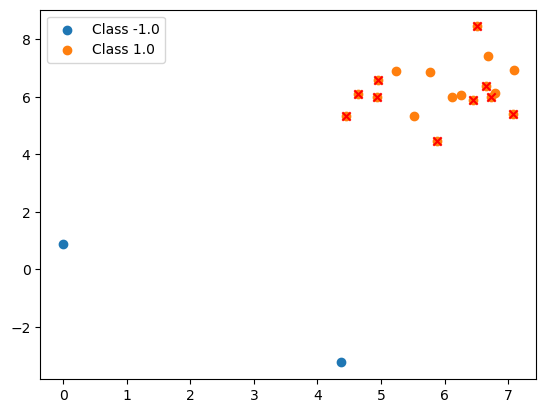

In [21]:
# Visualize the data
import matplotlib.pyplot as plt
for c in np.unique(y_test):
    plt.scatter(X_test[y_test==c, 0], X_test[y_test==c, 1], label=f'Class {c}')
for i in range(len(y_test)):
    # red crosses for misclassified points
    if y_test[i] != y_pred[i]:
        plt.scatter(X_test[i, 0], X_test[i, 1], color='red', marker='x')
plt.legend()
plt.show()